In [1]:
from neuron import h
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
import numpy as np
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
LJP = 0 # liquid junction potential in mV (bit cheesy to add this)

def I_t_curve(soma, ion, Vtest, Vhold, thold, tstep, ttail=2.0, ljp=0.0):
    clamp = h.VClamp(soma(0.5))
    # set integration time step
    h.dt = 0.001
    h.celsius = 35.0
    clamp.dur[0] = thold
    clamp.amp[0] = Vhold + ljp
    clamp.dur[1] = tstep
    clamp.amp[1] = Vtest + ljp
    clamp.dur[2] = ttail
    clamp.amp[2] = Vhold + ljp

    t = h.Vector().record(h._ref_t)
    if ion == 'na':
        i = h.Vector().record(soma(0.5)._ref_ina)
    elif ion == 'k':
        i = h.Vector().record(soma(0.5)._ref_ik)
    elif ion == 'h':
        i = h.Vector().record(soma(0.5)._ref_ih)
    elif ion == 'ca':
        i = h.Vector().record(soma(0.5)._ref_ica)
    h.finitialize(Vhold)
    h.continuerun(thold + tstep + ttail)
    t = np.array(t)
    i = np.array(i)
    del clamp
    return t, i

def I_V_curve(soma, ion, Vtests, Vhold, thold, tstep, ttail=2.0, method=min, ljp=0.0):
    h.dt = 0.001
    h.celsius = 35.0
    I_peaks = []
    for Vtest in Vtests:
        clamp = h.VClamp(soma(0.5))
        clamp.dur[0] = thold
        clamp.amp[0] = Vhold + ljp
        clamp.dur[1] = tstep
        clamp.amp[1] = Vtest + ljp
        clamp.dur[2] = ttail
        clamp.amp[2] = Vhold + ljp
        t = h.Vector().record(h._ref_t)
        if ion == 'na':
            i = h.Vector().record(soma(0.5)._ref_ina)
        elif ion == 'k':
            i = h.Vector().record(soma(0.5)._ref_ik)
        elif ion == 'h':
            i = h.Vector().record(soma(0.5)._ref_ih)
        elif ion == 'ca':
            i = h.Vector().record(soma(0.5)._ref_ica)
        # print(f"Running Vtest = {Vtest:+.1f} mV, "
        #     f"Vhold = {Vhold:+.1f} mV, "
        #     f"T = {h.celsius:.1f} °C, "
        #     f"ena = {soma(0.5).ena:.3f} mV")
        h.finitialize(Vhold)
        h.continuerun(thold + tstep + ttail)
        i = np.array(i)
        t = np.array(t)
        mask = (t >= thold) & (t <= thold + tstep*0.8)
        if method == min:
            I_peaks.append(np.min(i[mask]))
        elif method == max:
            I_peaks.append(np.max(i[mask]))
        elif method == 'mean':
            I_peaks.append(np.mean(i[mask]))
        else:
            raise ValueError("method must be min or max or mean")
        del clamp
    return Vtests, I_peaks

# def I_V_curve2(soma, ion, Vtests, Vhold, thold, tstep, ttail=5.0, method=min, ljp=0.0):
#     h.dt = 0.001
#     h.celsius = 35.0
#     I_peaks = []
#     for Vtest in Vtests:
#         clamp = h.SEClamp(soma(0.5))
#         clamp.rs = 0.001  
#         clamp.dur1 = thold; clamp.amp1 = (Vhold + ljp) 
#         clamp.dur2 = tstep; clamp.amp2 = (Vtest + ljp)
#         clamp.dur3 = ttail; clamp.amp3 = (Vhold + ljp)

#         t = h.Vector().record(h._ref_t)
#         if ion == 'na':
#             i = h.Vector().record(soma(0.5)._ref_ina)
#         elif ion == 'k':
#             i = h.Vector().record(soma(0.5)._ref_ik)
#         elif ion == 'h':
#             i = h.Vector().record(soma(0.5)._ref_ih)
#         elif ion == 'ca':
#             i = h.Vector().record(soma(0.5)._ref_ica)
#         h.finitialize(Vhold)
#         h.continuerun(thold + tstep + ttail)
#         i = np.array(i)
#         t = np.array(t)
#         #mask = (t >= thold) & (t <= thold + tstep)
#         mask = (t >= thold) & (t <= thold + 2.0)
#         if method == min:
#             I_peaks.append(np.min(i[mask]))
#         elif method == max:
#             I_peaks.append(np.max(i[mask]))
#         elif method == np.mean:
#             I_peaks.append(np.mean(i[mask]))
#         else:
#             raise ValueError("method must be min or max or mean")
#         del clamp
#     return Vtests, I_peaks


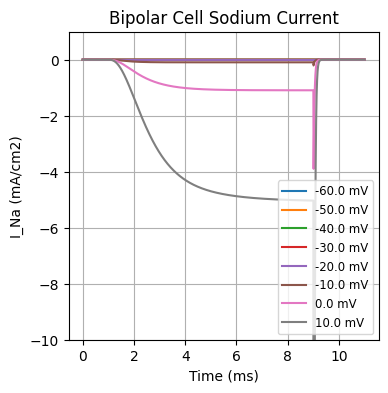

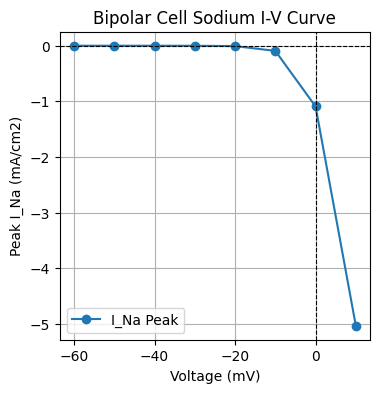

In [3]:
# Use np.min for Na+ inward current
soma = h.Section(name="soma")
# soma.L = soma.diam = 20 
# soma.nseg = 1
soma.insert("Bip_Na")
ena = 57.016 
for seg in soma:
    seg.ena = ena

Vs = np.arange(-60.0, 20.0, 10.0) 
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tna, ina_trace = I_t_curve(soma, ion='na', Vtest=Vtest, Vhold=-80.0, thold=1.0, tstep=8.0, ljp=LJP)
    plt.plot(np.array(tna), ina_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_Na (mA/cm2)')
plt.title('Bipolar Cell Sodium Current')
plt.legend(fontsize='small', loc='lower right')
plt.ylim(-10, 1)
plt.grid()
plt.show()


Vna, Ina_peak = I_V_curve(soma, ion='na', Vtests=Vs, Vhold=-80.0, thold=10.0, tstep=10.0, method=min, ljp=LJP)
plt.figure(figsize=(4,4))
plt.plot(Vna, Ina_peak, marker='o', label='I_Na Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_Na (mA/cm2)')
plt.title('Bipolar Cell Sodium I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

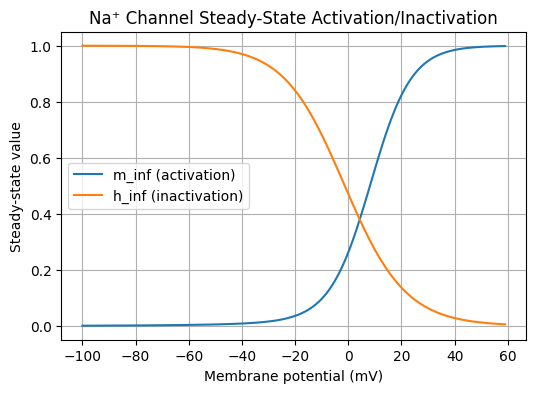

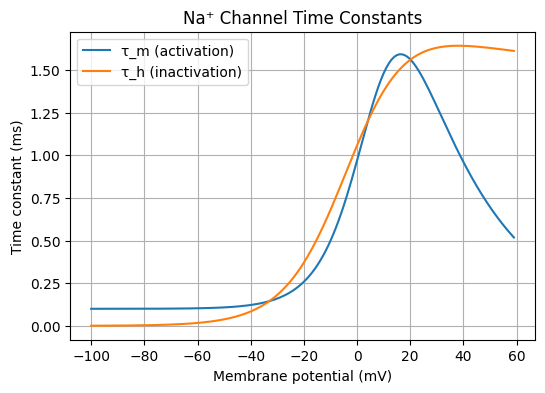

In [4]:
# Load your mechanism
soma = h.Section(name="soma")
soma.insert("Bip_Na")
h.celsius = 35.0
ena = 57.016
for seg in soma:
    seg.ena = ena

# Define voltage range
V = np.arange(-100, 60, 1)
m_inf, h_inf, tau_m, tau_h = [], [], [], []

# Loop through voltages and record gating parameters
for v in V:
    h.v_init = v
    h.finitialize(h.v_init)
    soma(0.5).Bip_Na.rates(v)
    m_inf.append(soma(0.5).Bip_Na.m_inf)
    h_inf.append(soma(0.5).Bip_Na.h_inf)
    tau_m.append(soma(0.5).Bip_Na.tau_m)
    tau_h.append(soma(0.5).Bip_Na.tau_h)

m_inf = np.array(m_inf)
h_inf = np.array(h_inf)
tau_m = np.array(tau_m)
tau_h = np.array(tau_h)

# Plot steady-state activation/inactivation
plt.figure(figsize=(6, 4))
plt.plot(V, m_inf, label="m_inf (activation)")
plt.plot(V, h_inf, label="h_inf (inactivation)")
plt.xlabel("Membrane potential (mV)")
plt.ylabel("Steady-state value")
plt.title("Na⁺ Channel Steady-State Activation/Inactivation")
plt.legend()
plt.grid(True)

# Plot time constants
plt.figure(figsize=(6, 4))
plt.plot(V, tau_m, label="τ_m (activation)")
plt.plot(V, tau_h, label="τ_h (inactivation)")
plt.xlabel("Membrane potential (mV)")
plt.ylabel("Time constant (ms)")
plt.title("Na⁺ Channel Time Constants")
plt.legend()
plt.grid(True)

plt.show()


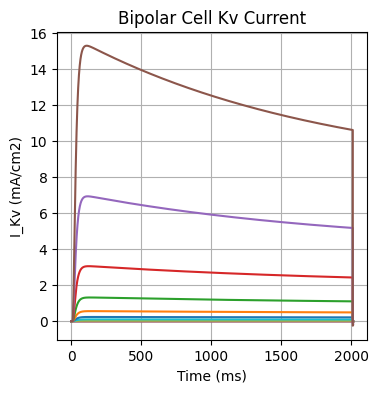

In [ ]:
# Use np.max for outward K+ current.
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1

soma.insert("Bip_Kv")
ek = -58 # mV
for seg in soma:
    seg.ek = ek

Vs = np.arange(-50.0, 30.0, 5.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tkv, ikv_trace = I_t_curve(soma, ion='k', Vtest=Vtest, Vhold=-60.0, thold=10.0, tstep=2000.0, ljp=LJP)
    plt.plot(np.array(tkv), ikv_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_Kv (mA/cm2)')
plt.title('Bipolar Cell Kv Current')
plt.grid()
plt.show()

Vkv, Ikv_peak = I_V_curve(soma, ion='k', Vtests=Vs, Vhold=-60.0, thold=10.0, tstep=2000.0, method=max, ljp=LJP)
plt.figure(figsize=(4,4))
plt.plot(Vkv, Ikv_peak, marker='o', label='I_Kv Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_Kv (mA/cm2)')
plt.title('Bipolar Cell Kv I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

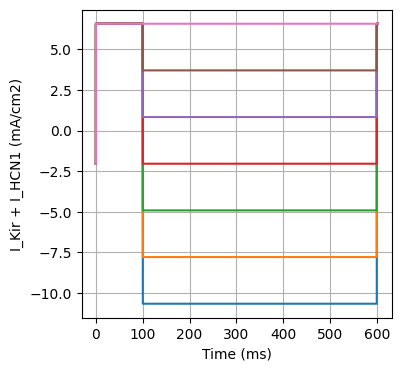

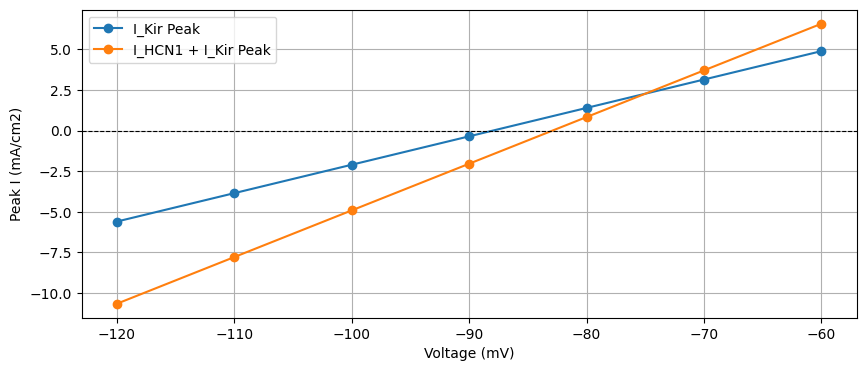

In [ ]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1

soma.insert("Bip_Kir")
soma.insert("Bip_HCN1")
ek = -58 # mVeh = -45 # mV
eh = -45 # mV
for seg in soma:
    seg.eh = eh
    seg.ek = ek

Vs = np.arange(-120.0, -50.0, 10.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tkir, ikir_trace = I_t_curve(soma, ion='k', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=LJP) 
    thcn1, ihcn1 = I_t_curve(soma, ion='h', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=LJP)
    plt.plot(np.array(tkir), ikir_trace + ihcn1, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_Kir + I_HCN1 (mA/cm2)')
plt.grid()
plt.show()

Vkir, Ikir_peak = I_V_curve(soma, ion='k', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=LJP)
Vhcn1, Ihcn1_peak = I_V_curve(soma, ion='h', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=LJP)
plt.figure(figsize=(10,4))
plt.plot(Vkir, Ikir_peak, marker='o', label='I_Kir Peak')
plt.plot(Vhcn1, (np.array(Ihcn1_peak) + np.array(Ikir_peak)), marker='o', label='I_HCN1 + I_Kir Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I (mA/cm2)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
#plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

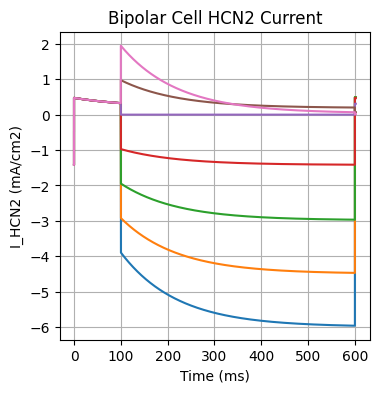

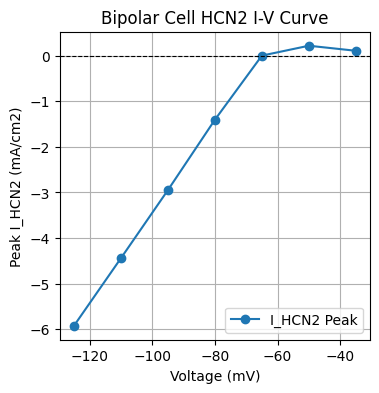

In [ ]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1

soma.insert("Bip_HCN2")
eh = -45 # mV
for seg in soma:
    seg.eh = eh

Vs = np.arange(-125.0, -20.0, 15.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    thcn2, ihcn2_trace = I_t_curve(soma, ion='h', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=LJP)
    plt.plot(np.array(thcn2), ihcn2_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_HCN2 (mA/cm2)')
plt.title('Bipolar Cell HCN2 Current')
plt.grid()
plt.show()

Vhcn2, Ihcn2_peak = I_V_curve(soma, ion='h', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=LJP)
plt.figure(figsize=(4,4))
plt.plot(Vhcn2, Ihcn2_peak, marker='o', label='I_HCN2 Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_HCN2 (mA/cm2)')
plt.title('Bipolar Cell HCN2 I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
#plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

KeyboardInterrupt: 

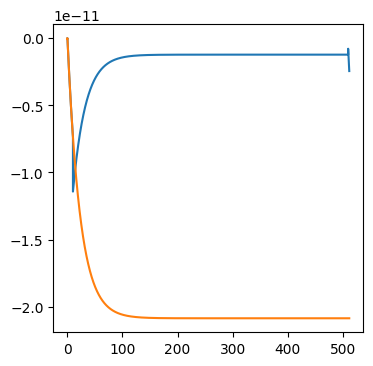

In [ ]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1
soma.insert("Bip_caconc")
soma.insert("Bip_CaT")

area_um2 = np.pi * soma.L * soma.diam
vol_um3 = area_um2 * 0.1  # shell thickness 0.1 µm
soma(0.5).Bip_caconc.area_um2 = area_um2
soma(0.5).Bip_caconc.vol_um3 = vol_um3
ek = -58 # mV
for seg in soma:
    seg.ek = ek 

Vs = np.arange(-80.0, 40.0, 10.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tcat, icat_trace = I_t_curve(soma, ion='ca', Vtest=Vtest, Vhold=-70.0, thold=10.0, tstep=500.0, ljp=LJP)
    plt.plot(np.array(tcat), icat_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_CaT (mA/cm2)')
plt.title('Bipolar Cell CaT Current')
#plt.legend(fontsize='small', loc='upper right')
plt.grid()
plt.show()


Vcat, Icat_peak = I_V_curve(soma, ion='ca', Vtests=Vs, Vhold=-80.0, thold=10.0, tstep=500.0, method=min, ljp=LJP)
plt.figure(figsize=(10,4))
plt.plot(Vcat, Icat_peak, marker='o', label='I_CaT Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_CaT (mA/cm2)')
plt.title('Bipolar Cell CaT I-V Curve') 
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
#plt.legend()
plt.grid()
plt.show()

--- Initial conditions ---
Assigned area = 1256.6 µm², check: 1256.6 µm²
Assigned submembrane volume = 125.7 µm³, check: 125.7 µm³
gcalbar = 5.0
cai0 = 5e-05
vshift = 90.0


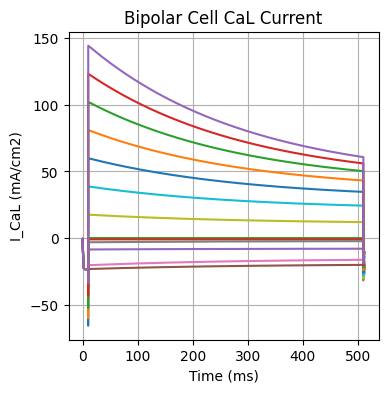

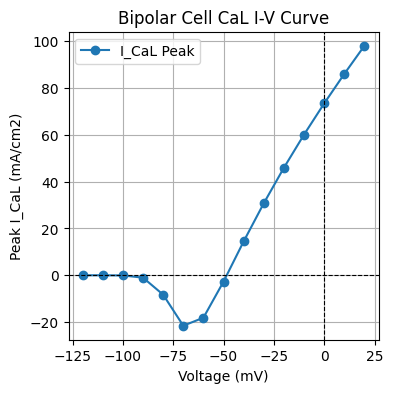

In [ ]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  
soma.nseg = 1
soma.insert("Bip_caconc")
soma.insert("Bip_CaL")

area_um2 = np.pi * soma.L * soma.diam
vol_um3 = area_um2 * 0.1  # shell thickness 0.1 µm
soma(0.5).Bip_caconc.area_um2 = area_um2
soma(0.5).Bip_caconc.vol_um3 = vol_um3
soma(0.5).Bip_CaL.gcalbar = 5 
#soma(0.5).Bip_CaL.vshift = 0
ek = - 58 # mV
for seg in soma:
    seg.ek = ek

print(f"--- Initial conditions ---")
print(f"Assigned area = {area_um2:.1f} µm², check: {soma(0.5).Bip_caconc.area_um2:.1f} µm²")
print(f"Assigned submembrane volume = {vol_um3:.1f} µm³, check: {soma(0.5).Bip_caconc.vol_um3:.1f} µm³")
print(f"gcalbar = {soma(0.5).Bip_CaL.gcalbar}")
print(f"cai0 = {soma(0.5).cai}")
print(f"vshift = {soma(0.5).Bip_CaL.vshift}")

Vs = np.arange(-120.0, 30.0, 10.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tcal, ical_trace = I_t_curve(soma, ion='ca', Vtest=Vtest, Vhold=-70.0, thold=10.0, tstep=500.0, ljp=LJP)
    plt.plot(np.array(tcal), ical_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_CaL (mA/cm2)')
plt.title('Bipolar Cell CaL Current')
plt.grid()
plt.show()

Vcal, Ical_peak = I_V_curve(soma, ion='ca', Vtests=Vs, Vhold=-70.0, thold=10.0, tstep=500.0, method='mean', ljp=LJP)
plt.figure(figsize=(4,4))
plt.plot(Vcal, Ical_peak, marker='o', label='I_CaL Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_CaL (mA/cm2)')
plt.title('Bipolar Cell CaL I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()
